In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
%matplotlib inline
from autograd import grad
import autograd.numpy as np

from sklearn.datasets import load_digits
data = load_digits()
X,Y = load_digits().data,load_digits().target
X.shape

(1797, 64)

In [2]:
# in a triplet network, the loss is defined on triplets of observations

In [3]:
def triplet_loss_paper(distance_close,distance_far):
    ''' loss function given two distances from the triplet (a,b,c)
    where distance_close=d(a,b), the distance between two points that
    should be close, and distance_far=d(a,c), the 
    distance between two points that should be far.
    
    see page 3 of: http://arxiv.org/abs/1412.6622'''
    exp_close = np.exp(distance_close)
    exp_far = np.exp(distance_close)
    
    
    d_plus = exp_close / (exp_close + exp_far)
    d_minus = exp_far / (exp_close + exp_far)
    
    return (d_plus-d_minus)**2

def modified_triplet_loss(distance_close,distance_far):
    return distance_far - distance_close

def zero_one_triplet_loss(distance_close,distance_far):
    return 1.0*(distance_far < distance_close)

def distance(x,y):
    return np.sqrt(np.sum((x-y)**2))
                 
def triplet_objective(transformation,x,x_close,x_far,
                      triplet_loss=modified_triplet_loss):
    '''for a metric embedding, we can transform each point separately'''
    t_a,t_b,t_c = [transformation(point) for point in (x,x_close,x_far)]
    
    return triplet_loss(distance(t_a,t_b),distance(t_a,t_c))

def generate_triplet(X,Y):
    x_ind = np.random.randint(len(X))
    x,y = X[x_ind],Y[x_ind]
    x_close_ind = np.random.randint(len(X[Y==y]))
    x_far_ind = np.random.randint(len(X[Y!=y]))
    x_close = X[Y==y][x_close_ind]
    x_far = X[Y!=y][x_far_ind]
    return x,x_close,x_far

In [14]:
%timeit generate_triplet(X,Y)

The slowest run took 6.65 times longer than the fastest. This could mean that an intermediate result is being cached 
10000 loops, best of 3: 194 µs per loop


In [4]:
from time import time
t = time()
triplets = [generate_triplet(X[:1000],Y[:1000]) for i in range(10000)]
triplets_test = [generate_triplet(X[1000:],Y[1000:]) for i in range(10000)]
print(time() - t)

19.8850970268


In [5]:
triplets = np.array(triplets)
triplets.shape

(10000, 3, 64)

In [6]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)
transform = lambda x: pca.transform(x)[0]

In [7]:
triplet_objective(pca.transform,*triplets[10])

-12.13665727922605

In [8]:
t =time()
obj = [triplet_objective(transform,*triplet) for triplet in triplets]
print(time() - t)

0.717976093292


In [9]:
np.min(obj),np.max(obj)

(-32.548446540413366, 49.973049670121881)

In [142]:
def mahalanobis(x,y,diag):
    return np.sqrt(np.dot((x-y)*diag,(x-y)))
    #return np.sqrt(np.sum(np.abs(np.dot(np.outer((x-y),diag),(x-y)))))
    #return np.sqrt(np.dot(np.outer((x-y),np.diag(diag)),x-y))

In [10]:
def weighted_metric(x,y,a,W):
    ''' a is a non-negative vector of length len(x)=len(y), w is a len(x)-by-len(x) real matrix'''
    return np.sqrt(np.dot(np.dot(np.dot(np.dot((x-y).T,np.diag(a)),W),np.diag(a).T),(x-y)))

In [13]:
weighted_metric(np.ones(2),np.ones(2)*2,np.ones(2),np.ones((2,2)))

2.0

In [14]:
%timeit weighted_metric(np.ones(2),np.ones(2)*2,np.ones(2),np.ones((2,2)))

10000 loops, best of 3: 37.5 µs per loop


In [143]:
mahalanobis(np.ones(2),np.ones(2),np.ones(2))

0.0

In [ ]:
pca.transform(

In [146]:
mahalanobis(pca.transform(X[0])[0],pca.transform(X[1])[0],np.ones(2))

43.042041614801654

In [47]:
pca.transform(X[0])

array([[  1.25946645, -21.27488348]])

In [147]:
def mahalanobis_obj(weights,triplet,triplet_loss=modified_triplet_loss):
    return triplet_loss(mahalanobis(triplet[0],triplet[1],weights),
                        mahalanobis(triplet[0],triplet[2],weights))

def batch_mahalanobis_obj(weights,triplets,triplet_loss=modified_triplet_loss):
    loss = 0
    for i in range(len(triplets)):
        loss += mahalanobis_obj(weights,triplets[i],triplet_loss)
    return loss / len(triplets)


print(mahalanobis_obj(np.ones(len(triplets[0][0])),triplets[0]))
print(batch_mahalanobis_obj(np.ones(len(triplets[0][0])),triplets[:100]))

23.0999475116
14.2518042666


In [148]:
grad(lambda w:mahalanobis_obj(w,triplets[0]))(np.ones(len(triplets[0][0])))

array([ 0.        ,  0.        ,  0.25671086, -0.22016996, -0.08341364,
        0.01426944, -0.04613841, -0.01953662,  0.        ,  0.        ,
        0.23717424, -1.86124575, -1.57219751, -0.01953662,  0.02153712,
        0.        ,  0.        ,  0.01026843, -0.39599951,  0.16429495,
        0.07287929, -0.05587501,  0.01026843,  0.        ,  0.        ,
        0.        ,  1.47865453,  1.40050807,  0.08088131, -0.45414094,
       -0.06787803,  0.        ,  0.        , -0.07814647,  0.83174318,
        2.55057271,  2.62871917, -0.27151213, -0.75072277,  0.        ,
        0.        , -0.31258587, -0.27151213,  2.31039771, -0.22016996,
        1.70002725, -0.01953662,  0.        ,  0.        ,  0.16429495,
        0.65591363, -0.74719019,  0.81220656,  1.24248055,  0.        ,
        0.        ,  0.        ,  0.        ,  0.29151717, -0.91622048,
        2.62871917,  0.36966363,  0.        ,  0.        ])

In [547]:
def sgd(objective,dataset,init_point,n_iter=100,step_size=0.01,seed=0,
        stoch_select=False,norm=False,store_intermediates=True):
    ''' objective takes in a parameter vector and an array of data'''
    np.random.seed(seed)
    x = init_point
    if store_intermediates:
        testpoints = np.zeros((n_iter,len(init_point)))
        testpoints[0] = x

    for i in range(1,n_iter):
        ind = np.random.randint(len(dataset))
        obj_grad = grad(lambda p:objective(p,dataset[ind]))
        raw_grad = obj_grad(x)
        #raw_grad = obj_grad(testpoints[i-1])
        gradient = np.nan_to_num(raw_grad)
        x = x-gradient*step_size
        if norm:
            x = np.abs(x) / np.sum(np.abs(x))
        #print(gradient,raw_grad)
        if store_intermediates:
            testpoints[i] = x
    return np.array(testpoints)

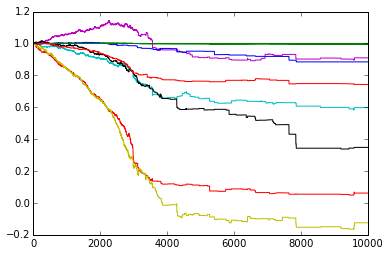

In [173]:
results = sgd(mahalanobis_obj,triplets,np.ones(len(triplets[0][0])),n_iter=10000,step_size=0.001)
plt.plot(results[:,:10]);

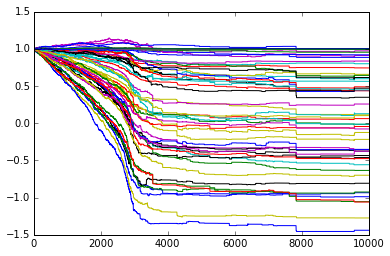

In [174]:
plt.plot(results);

In [175]:
len(triplets[0][0])

64

In [176]:
batch_mahalanobis_obj(np.ones(64),triplets,zero_one_triplet_loss)

0.1188

In [177]:
batch_mahalanobis_obj(results[-1],triplets,zero_one_triplet_loss)

0.0016000000000000001

In [178]:
batch_mahalanobis_obj(np.ones(64),triplets_test,zero_one_triplet_loss),batch_mahalanobis_obj(results[-1],triplets_test,zero_one_triplet_loss)

(0.1149, 0.0023999999999999998)

In [179]:
grad(lambda w:batch_mahalanobis_obj(w,triplets[:100]))(np.ones(len(triplets[0][0])))

array([  0.00000000e+00,  -1.39697931e-03,   1.93212827e-01,
         9.36037000e-02,  -2.18671192e-02,   2.76214612e-01,
         2.37870490e-02,   2.35728505e-03,   8.39181358e-05,
         7.15165796e-02,   2.02456880e-01,   6.79819088e-02,
         5.27159976e-02,   1.75685569e-01,  -1.43022042e-02,
         8.70477997e-03,   0.00000000e+00,   9.58738064e-02,
         4.04692027e-01,   2.39708052e-01,   2.32050097e-01,
         4.58627400e-01,   9.05272474e-03,   6.37398746e-04,
         0.00000000e+00,   8.48901422e-02,   3.77995955e-01,
         2.99422449e-01,   2.31194348e-01,   1.61737823e-01,
         5.18772763e-02,   0.00000000e+00,   0.00000000e+00,
         8.14545187e-02,   3.77108939e-01,   2.45308749e-01,
         2.12929678e-01,   7.15265485e-02,   7.73420477e-02,
         0.00000000e+00,   1.36757132e-03,   2.59236001e-02,
         6.07959753e-01,   4.05438589e-01,   3.48175160e-01,
        -4.21190563e-03,   1.39783702e-01,  -4.66713294e-04,
         8.54732075e-05,

In [121]:
cheap_triplet_batch = lambda batch_size=50: triplets[np.random.randint(0,len(triplets),batch_size)]

In [66]:
%timeit cheap_triplet_batch()

The slowest run took 11.05 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 13.5 µs per loop


In [134]:
example_triplet_batch = cheap_triplet_batch()
#stoch_mahalanobis_grad = grad(lambda weights:batch_mahalanobis_obj(weights,cheap_triplet_batch()))
mahalanobis_grad = grad(lambda weights:batch_mahalanobis_obj(weights,example_triplet_batch))

In [180]:
mahalanobis_grad(np.ones(64))

array([  0.00000000e+00,  -6.96726310e-03,   3.17271575e-01,
         2.54622029e-01,  -9.71341500e-02,   1.45346684e-01,
         1.70738525e-01,  -1.85897354e-02,  -2.12905602e-03,
        -1.11509717e-02,   4.55695827e-01,   6.62022204e-03,
         6.71817729e-02,   2.94194082e-01,   6.32200166e-02,
         5.92929531e-03,   0.00000000e+00,  -1.84055807e-02,
         8.13803529e-02,   6.29166708e-02,   2.24273293e-01,
         3.05723228e-01,  -3.46408863e-02,   2.25839244e-03,
         0.00000000e+00,   4.68715055e-02,   3.81600678e-01,
         2.66462450e-01,   2.50936457e-01,   6.26198973e-02,
         8.62191936e-02,  -1.00776028e-04,   0.00000000e+00,
         2.16081843e-01,   2.95408092e-01,   1.93225736e-01,
         2.51780631e-01,   1.38675144e-01,   5.51463743e-02,
         0.00000000e+00,   1.58750159e-04,   1.32676238e-01,
         6.55123063e-01,   4.16378105e-01,  -1.04148488e-02,
        -7.09007307e-02,   3.57721105e-02,   5.78278405e-04,
         0.00000000e+00,

In [181]:
from scipy.optimize import minimize

result = minimize(lambda w:batch_mahalanobis_obj(w,cheap_triplet_batch()),np.ones(64),jac=mahalanobis_grad)

TypeError: only integer arrays with one element can be converted to an index

In [83]:
result

   status: 2
  success: False
     njev: 42
     nfev: 42
 hess_inv: array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1]])
      fun: nan
        x: array([  1.00000000e+00,  -2.04972142e+00,  -3.28804201e+02,
        -8.20758617e+01,   1.82302864e+02,  -5.19554039e+02,
        -1.68789951e+02,   9.33535365e+00,   1.23800285e+00,
        -1.06486690e+02,   4.32413100e+01,  -3.01148889e+01,
        -1.16471428e+01,  -2.23832204e+02,  -2.62675480e+01,
        -1.39457164e+00,   1.00000000e+00,  -7.95163061e+01,
        -1.84097946e+02,  -6.53462261e+01,  -3.22324761e+02,
        -3.30967046e+02,   4.62477776e+01,   2.86011480e-01,
         1.00000000e+00,   3.67650376e+01,  -2.90868142e+02,
        -1.75700188e+02,  -2.72414512e+02,  -5.39388205e+02,
        -1.23128143e+02,   1.00000000e+00,   1.00000000e+00,
        -7.32037147e+01,  -4

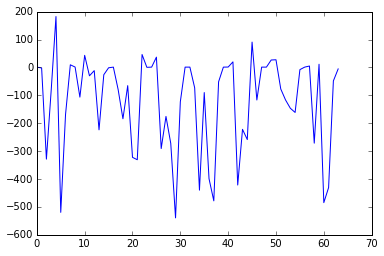

In [85]:
plt.plot(result.x)

In [118]:
mahalanobis(triplets[0][0],triplets[0][1],result.x)

1092.8740552667703

In [109]:
x,y=triplets[0][1],triplets[0][0]
np.sum(np.abs(np.dot(np.outer((x-y),result.x),(x-y))))

1194373.7006752358

In [106]:
np.outer(x-y,x-y).shape

(64, 64)

In [117]:
batch_mahalanobis_obj(result.x,triplets[:10])

302.77880056006222

In [2]:
def feedforward_network

In [5]:
import keras

In [182]:
def objective(M):
    return np.sum(np.abs(M))

grad(objective)(np.ones((10,10)))

array([[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]])

In [183]:
def tripletify_trajectory(X,tau_1=5,tau_2=20):
    X_triplets = []
    for i in range(len(X) - tau_2):
        X_triplets.append((X[i],X[i+tau_1],X[i+tau_2]))
    return X_triplets

In [186]:
X_ = tripletify_trajectory(X)

(array([  0.,   0.,   5.,  13.,   9.,   1.,   0.,   0.,   0.,   0.,  13.,
         15.,  10.,  15.,   5.,   0.,   0.,   3.,  15.,   2.,   0.,  11.,
          8.,   0.,   0.,   4.,  12.,   0.,   0.,   8.,   8.,   0.,   0.,
          5.,   8.,   0.,   0.,   9.,   8.,   0.,   0.,   4.,  11.,   0.,
          1.,  12.,   7.,   0.,   0.,   2.,  14.,   5.,  10.,  12.,   0.,
          0.,   0.,   0.,   6.,  13.,  10.,   0.,   0.,   0.]),
 array([  0.,   0.,  12.,  10.,   0.,   0.,   0.,   0.,   0.,   0.,  14.,
         16.,  16.,  14.,   0.,   0.,   0.,   0.,  13.,  16.,  15.,  10.,
          1.,   0.,   0.,   0.,  11.,  16.,  16.,   7.,   0.,   0.,   0.,
          0.,   0.,   4.,   7.,  16.,   7.,   0.,   0.,   0.,   0.,   0.,
          4.,  16.,   9.,   0.,   0.,   0.,   5.,   4.,  12.,  16.,   4.,
          0.,   0.,   0.,   9.,  16.,  16.,  10.,   0.,   0.]),
 array([  0.,   0.,   3.,  13.,  11.,   7.,   0.,   0.,   0.,   0.,  11.,
         16.,  16.,  16.,   2.,   0.,   0.,   4.,  16.,   

In [198]:
def deviation_ify_triplets(triplets):
    deviations = np.zeros((len(triplets),2,len(triplets[0][0])))
    for i,(a,b,c) in enumerate(triplets):
        deviations[i][0] = a-b
        deviations[i][1] = a-c
    return deviations

In [199]:
deviations = deviation_ify_triplets(X_)

In [324]:
def weighted_objective(weights,deviation_pair,norm=False):
    close = np.dot(deviation_pair[0],np.abs(weights))
    far = np.dot(deviation_pair[1],np.abs(weights))
    if norm:
        return (close-far) / (close+far)
    else:
        return close-far

In [289]:
weighted_objective(np.ones(64),deviations[0])

0.054945054945054944

In [290]:
stoch_objective = lambda weights:weighted_objective(weights,deviations[np.random.randint(len(deviations))])

In [291]:
stoch_objective(np.ones(64))

3.0

In [334]:
results = sgd(weighted_objective,deviations,np.ones(64),n_iter=10000,step_size=0.001)

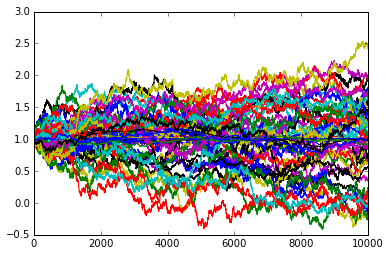

In [335]:
plt.plot(results);

In [336]:
from msmbuilder.example_datasets import AlanineDipeptide,FsPeptide
ala = AlanineDipeptide().get()
ala_traj = ala.trajectories[0]
fs = FsPeptide().get()
fs_traj = fs.trajectories[0]

loading trajectory_1.xtc...
loading trajectory_10.xtc...
loading trajectory_11.xtc...
loading trajectory_12.xtc...
loading trajectory_13.xtc...
loading trajectory_14.xtc...
loading trajectory_15.xtc...
loading trajectory_16.xtc...
loading trajectory_17.xtc...
loading trajectory_18.xtc...
loading trajectory_19.xtc...
loading trajectory_2.xtc...
loading trajectory_20.xtc...
loading trajectory_21.xtc...
loading trajectory_22.xtc...
loading trajectory_23.xtc...
loading trajectory_24.xtc...
loading trajectory_25.xtc...
loading trajectory_26.xtc...
loading trajectory_27.xtc...
loading trajectory_28.xtc...
loading trajectory_3.xtc...
loading trajectory_4.xtc...
loading trajectory_5.xtc...
loading trajectory_6.xtc...
loading trajectory_7.xtc...
loading trajectory_8.xtc...
loading trajectory_9.xtc...


In [295]:
ala_traj

<mdtraj.Trajectory with 9999 frames, 22 atoms, 3 residues, without unitcells at 0x3771693d0>

In [296]:
from msmbuilder.featurizer import DihedralFeaturizer
dhf = DihedralFeaturizer()
dhft = dhf.transform([ala_traj])[0]

In [297]:
dhft.shape

(9999, 4)

In [364]:
deviations_ala = deviation_ify_triplets(tripletify_trajectory(dhft,tau_1=5,tau_2=10))

In [365]:
results = sgd(weighted_objective,deviations_ala,np.ones(4),n_iter=10000,step_size=0.01)

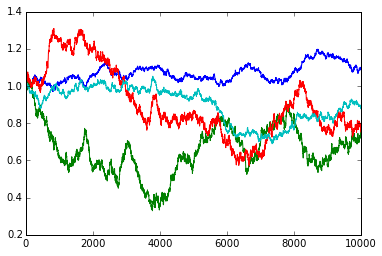

In [366]:
plt.plot(results);

In [273]:
import sys
sys.path.append('../projects/metric-learning')
import weighted_rmsd

In [301]:
from weighted_rmsd import compute_atomwise_deviation,compute_atomwise_deviation_xyz

In [367]:
ala_triplets = tripletify_trajectory(ala_traj,tau_1=5,tau_2=10)
fs_triplets = tripletify_trajectory(fs_traj,tau_1=5,tau_2=10)

In [303]:
a = ala_triplets[0][0]
a.n_atoms

22

In [304]:
def deviation_ify_protein_triplets(triplets):
    deviations = np.zeros((len(triplets),2,triplets[0][0].n_atoms))
    for i,(a,b,c) in enumerate(triplets):
        deviations[i][0] = compute_atomwise_deviation(a,b)
        deviations[i][1] = compute_atomwise_deviation(a,c)
    return deviations

In [514]:
ala_deviations = deviation_ify_protein_triplets(ala_triplets)
fs_deviations = deviation_ify_protein_triplets(fs_triplets)

In [515]:
fs_atoms = fs_deviations.shape[-1]

In [516]:
results_ala = sgd(weighted_objective,ala_deviations,np.ones(22),n_iter=10000,step_size=0.1)
results_fs = sgd(weighted_objective,fs_deviations,np.ones(fs_atoms),n_iter=10000,step_size=0.1)

In [517]:
norm_results_ala = 22*results_ala / np.outer(results_ala.sum(1),np.ones(results_ala.shape[1]))
norm_results_fs = fs_atoms*results_fs / np.outer(results_fs.sum(1),np.ones(fs_atoms))

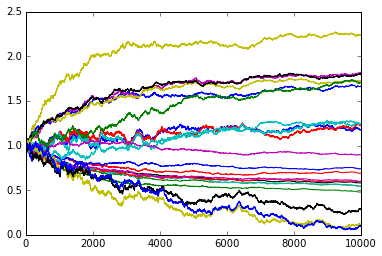

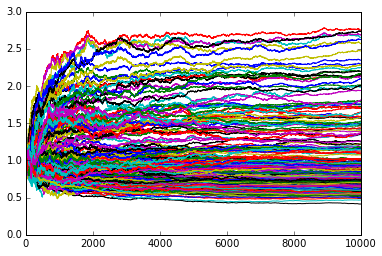

In [518]:
plt.plot(norm_results_ala);
plt.figure()
plt.plot(norm_results_fs);

In [519]:
def zero_one_weighted_deviation_loss(weights,deviation_pair):
    return 1.0*(np.dot(deviation_pair[0],weights) > np.dot(deviation_pair[1],weights))

In [520]:
sum([zero_one_weighted_deviation_loss(np.ones(22),a) for a in ala_deviations]) / len(ala_deviations)

0.4206627290019021

In [521]:
sum([zero_one_weighted_deviation_loss(np.abs(results_ala[-1]),a) for a in ala_deviations]) / len(ala_deviations)

0.40955050555611172

In [522]:
sum([zero_one_weighted_deviation_loss(np.ones(fs_atoms),a) for a in fs_deviations]) / len(fs_deviations)

0.31621621621621621

In [523]:
sum([zero_one_weighted_deviation_loss(np.abs(results_fs[-1]),a) for a in fs_deviations]) / len(fs_deviations)

0.30760760760760758

In [363]:
from weighted_rmsd import compute_kinetic_weights

In [ ]:
compute_kinetic_weights(tra

In [319]:
print('residues with increased weight here: ',np.arange(len(norm_results))[norm_results[-1]>1])

('residues with increased weight here: ', array([11, 12, 13, 15]))


In [372]:
from MDAnalysis.analysis import align

In [484]:
a = np.array(fs_traj[0].xyz[0],dtype=np.float64)
b = np.array(fs_traj[1].xyz[0],dtype=np.float64)
a

array([[ 1.11600006, -1.08800006,  1.04900002],
       [ 1.13700008, -0.96800005,  1.028     ],
       [ 1.05200005, -1.12600005,  1.18000007],
       [ 1.01600003, -1.03800011,  1.23200011],
       [ 0.97300005, -1.20000005,  1.16300011],
       [ 1.12100005, -1.18000007,  1.24600005],
       [ 1.12800002, -1.18200004,  0.95800006],
       [ 1.13200009, -1.27800012,  0.98900002],
       [ 1.22500002, -1.15900004,  0.83800006],
       [ 1.31500006, -1.10600007,  0.86900002],
       [ 1.2750001 , -1.29900002,  0.79700005],
       [ 1.32800007, -1.34100008,  0.88200003],
       [ 1.34800005, -1.27900004,  0.71900004],
       [ 1.18800008, -1.36100006,  0.77300006],
       [ 1.15900004, -1.07600009,  0.72700006],
       [ 1.22800004, -0.99300003,  0.66300005],
       [ 1.02900004, -1.10900009,  0.70700002],
       [ 0.97500002, -1.1730001 ,  0.76300001],
       [ 0.95600003, -1.06400001,  0.58700001],
       [ 1.01800001, -1.0660001 ,  0.49800003],
       [ 0.84000003, -1.16500008,  0.571

In [410]:
align.rms.rmsd(a,b,np.ones(len(a)))

0.1967593781226804

In [412]:
grad(lambda w:align.rms.rmsd(a,b,w))(np.ones(len(a)))

TypeError: make_grad_np_mean() got an unexpected keyword argument 'dtype'

In [413]:
%timeit align.rms.rmsd(a,b)

The slowest run took 12.29 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 13 µs per loop


In [384]:
align.rms.rmsd(a,a,10*np.ones(fs_atoms))

4.640215302476424e-08

In [385]:
import numpy.linalg as la

In [389]:
u,s,v=la.svd(np.ones((10,10)))

In [396]:
def can_has_svd_derivative(m):
    u,s,v=la.svd(m)
    return np.sum(u)

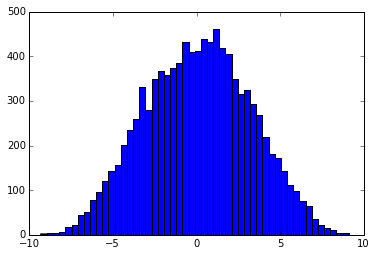

In [400]:
plt.hist([can_has_svd_derivative(np.random.randn(10,10)) for i in range(10000)],bins=50);

In [401]:
grad(can_has_svd_derivative)(np.ones((10,10)))

/Users/joshuafass/anaconda/envs/py27/lib/python2.7/site-packages/numpy/linalg/linalg.py:1327: DeprecationWarning: Implicitly casting between incompatible kinds. In a future numpy release, this will raise an error. Use casting="unsafe" if this is intentional.
  u, s, vt = gufunc(a, signature=signature, extobj=extobj)


TypeError: float() argument must be a string or a number

In [414]:
def can_has_det_deriv(m):
    return np.linalg.det(m)

In [416]:
np.random.seed(0)
m = np.random.randn(10,10)
np.linalg.det(m)

55.921478444018824

In [417]:
grad(np.linalg.det)(m)

array([[  3.26689297e+01,   2.41157719e+02,  -1.36510452e+02,
          2.70083908e+01,  -1.21420666e+02,  -1.02107211e+02,
         -4.34478612e+00,  -1.29692486e+02,  -7.47336897e+01,
          1.91508128e+02],
       [ -5.03241338e+01,  -5.25953301e+02,   2.73235722e+02,
         -5.25773306e+01,   3.30054896e+02,   2.27235382e+02,
          7.36456391e+00,   2.82679054e+02,   1.69057371e+02,
         -4.66279585e+02],
       [ -1.15278778e+01,  -1.05033293e+01,   9.68732507e+00,
         -1.56991627e+00,   4.28698087e+00,  -7.95248784e+00,
          5.58982214e+00,   6.79406395e+00,   4.65312730e+00,
         -2.44705117e+00],
       [ -1.22245932e+01,  -1.57427909e+02,   8.36492880e+01,
         -2.33373075e+01,   7.57112260e+01,   4.55714745e+01,
          2.32892204e+01,   9.70634834e+01,   3.68251151e+01,
         -1.10831414e+02],
       [ -3.23354975e+01,  -2.04417611e+02,   1.19108721e+02,
         -1.37110905e+01,   1.02245409e+02,   6.72908784e+01,
          1.42964657e+01

In [481]:
def BC_w_vec(X,Y,m):
    M = np.diag(m)
    xx = np.dot(np.dot(X.T,M),X)
    xy = np.dot(np.dot(X.T,M),Y)
    yy = np.dot(np.dot(Y.T,M),Y)
    return 1-np.linalg.det(xy) / np.sqrt(np.linalg.det(xx) * np.linalg.det(yy))

In [482]:
BC_w_vec(fs_triplets_xyz[0][0],fs_triplets_xyz[0][1],np.ones(fs_atoms))

0.1010878238059435

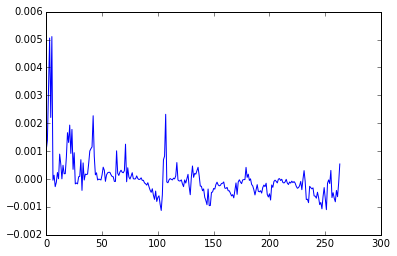

In [485]:
plt.plot(grad(lambda w:BC_w_vec(a,b,w))(np.ones(264)));

In [486]:
%timeit grad(lambda w:BC_w_vec(a,b,w))(np.ones(264))

100 loops, best of 3: 19.7 ms per loop


In [487]:
%timeit BC_w_vec(a,b,np.ones(264))

1000 loops, best of 3: 290 µs per loop


In [428]:
grad_bc = grad(lambda w:BC_w_vec(a,b,w))

In [430]:
%timeit grad_bc(np.ones(264))

100 loops, best of 3: 19.2 ms per loop


In [488]:
losses_unweighted = [zero_one_triplet_loss(BC_w_vec(a.xyz[0],b.xyz[0],np.ones(264)),BC_w_vec(a.xyz[0],c.xyz[0],np.ones(264))) for (a,b,c) in fs_triplets]

In [489]:
sum(losses_unweighted) / len(losses_unweighted)

0.24194194194194193

In [490]:
def wbc_obj(weights,triplet,triplet_loss=modified_triplet_loss):
    return triplet_loss(BC_w_vec(triplet[0],triplet[1],weights),
                        BC_w_vec(triplet[0],triplet[2],weights))

In [491]:
from msmbuilder.featurizer import RawPositionsFeaturizer as rpf

In [492]:
fs_triplets_xyz = [(a.xyz[0],b.xyz[0],c.xyz[0]) for (a,b,c) in fs_triplets]

2.40043997765


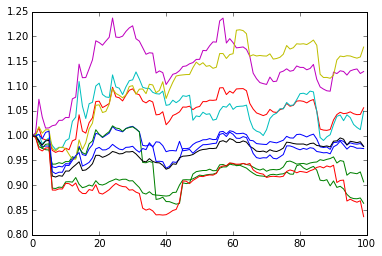

In [545]:
t = time()
results = sgd(wbc_obj,fs_triplets_xyz,np.ones(fs_atoms),n_iter=100,step_size=10)
plt.plot(results[:,:10]);
print(time()-t)

In [ ]:
results = sgd(wbc_obj,fs_triplets_xyz,np.ones(fs_atoms),n_iter=10000,step_size=1,store_intermediates=False)

In [541]:
losses_weighted = [zero_one_triplet_loss(BC_w_vec(a.xyz[0],b.xyz[0],results[-1]),BC_w_vec(a.xyz[0],c.xyz[0],results[-1])) for (a,b,c) in fs_triplets]

In [542]:
sum(losses_weighted) / len(losses_weighted)

0.26056056056056054

In [472]:
# idea: instead of picking the points randomly, you can pick time-points on either side of detected change-points